In [44]:
import pandas as pd
import numpy as np

# Data Preparation

In [45]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [46]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [47]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [48]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [49]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [50]:
categorical = df.select_dtypes(include=['object', 'string']).columns.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [51]:
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

In [52]:
df[categorical].isnull().sum()

lead_source          128
industry             134
employment_status    100
location              63
dtype: int64

In [53]:
df[categorical] = df[categorical].fillna("NA")

In [54]:
df[categorical].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [55]:
df[numerical].isnull().sum()

number_of_courses_viewed      0
annual_income               181
interaction_count             0
lead_score                    0
dtype: int64

In [56]:
df[numerical] = df[numerical].fillna(0.0)

In [57]:
df[numerical].isnull().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [85]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

In [59]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [60]:
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

In [61]:
df.shape

(1462, 9)

# Question 1

In [62]:
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]

In [63]:
y_train = df_train["converted"].values

In [64]:
del df_train["converted"]

In [65]:
roc_values = {}

for col in numerical:
    try:
        auc = roc_auc_score(y_train, df_train[col])
        roc_values[col] = auc
    except ValueError:
        roc_values[col] = None

roc_sorted = pd.Series(roc_values).sort_values(ascending=False)
print(roc_sorted)

number_of_courses_viewed    0.763568
interaction_count           0.738270
lead_score                  0.614499
annual_income               0.551958
dtype: float64


# Question 2

In [66]:
y_val = df_val["converted"].values

In [67]:
del df_val["converted"]

In [68]:
df_train_dict = df_train[categorical + numerical].to_dict(orient='records')
df_val_dict = df_val[categorical + numerical].to_dict(orient='records')

In [69]:
dv = DictVectorizer(sparse=False)

In [70]:
X_train = dv.fit_transform(df_train_dict)
X_val = dv.transform(df_val_dict)

In [41]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [71]:
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [73]:
y_pred = model.predict_proba(X_val)[:, 1]

In [75]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [76]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [77]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [83]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

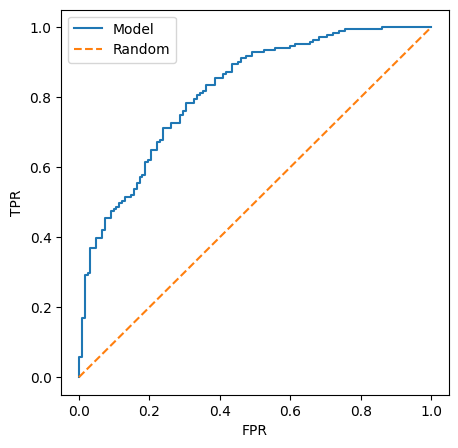

In [86]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [88]:
round(auc(fpr, tpr), 3)

0.817

# Question 3

In [91]:
thresholds = np.linspace(0, 1, 101)

precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp/(tp + fp)
    r = tp/(tp + fn)

    precisions.append(p)
    recalls.append(r)

/tmp/ipykernel_6130/649195401.py:19: RuntimeWarning: invalid value encountered in scalar divide
  p = tp/(tp + fp)


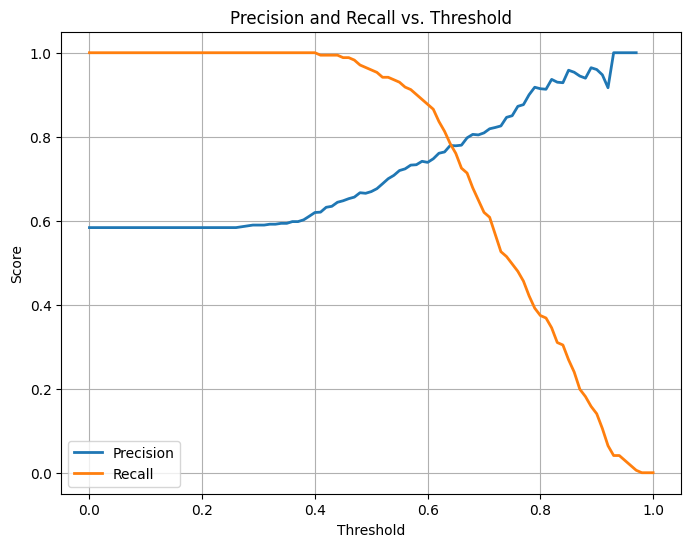

In [92]:
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()